# Abell 1656: the Coma Cluster of Galaxies
This notebook is based on the EURO-VO tutorial: "Abell 1656: The Coma Cluster of Galaxies" (http://www.euro-vo.org/?q=science/scientific-tutorials) by Massimo Ramella & Giulia Iafrate (INAF - Osservatorio Astronomico di Trieste). The tutorial was later updated by Caroline Bot, Thomas Boch, Jenny G. Sorce and Katharina A. Lutz (all CDS, CNRS, Observatoire astronomique de Strasbourg). This notebook by Katharina A. Lutz, Thomas Boch, Matthieu Bauman and Ana Nebot (all CDS, CNRS, Observatoire astronomique de Strasbourg) shows how to perform the tasks of the original tutorial from within a Jupyter notebook.

## Introduction
The goals of this notebook tutorial are:
 - Examine the Coma cluster of galaxies (Abell 1656) using services and data from the virtual observatory withinin a jupyter notebook in order to perform a quick evaluation of the mean redshift and velocity dispersion of the cluster. Both measurements are important to study the evolution of galaxy clusters. To do so we use redshifts and photometry (Petrosian r magnitude) from the SDSS survey and then add redshifts from the CAIRNS survey (Rines et al. 2003) in order to improve the completeness of the redshift sample.
 - Search the MAST archive for HST spectra in the region of the Coma cluster.
 - Download a spectrum from MAST and do a quick analysis of the redshift of the emission lines in the spectrum. 
 
For our analysis we need to following python packages: astropy (3.2.1) and the affiliated packages astroquery (0.3.10.dev), specutils(0.5.2), and pyvo (0.9.3), as well as ipyaladin (0.1.6), matplotlib (3.1.1), seaborn (0.9.0) and numpy (1.17.0). All packages can be installed via

    pip install [package name]
    
The warning package will only be in use until the pyvo team has removed an astropy deprecation warning.  

In [1]:
import ipyaladin.aladin_widget as ipyal
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from specutils import Spectrum1D, SpectralRegion
import specutils.analysis as spec_ana
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import seaborn as sns
import numpy as np
import pyvo

import warnings 
warnings.filterwarnings('ignore')

print('All done and ready to go :) ')

All done and ready to go :) 


## Display the region of Abell 1656 in Aladin lite
We start by displaying the Coma Cluster in an Aladin Lite widget. We will centre the DSS2 colour images (`survey='P/DSS2/color'`) on Abell 1656 (`target='A1656'`) and set the field of view to 0.7deg (`fov=0.7`). At the distance of Coma, our field of view corresponds to approximately 1Mpc a region large enough for our purposes. 

Note that if you are using Jupyter lab you can now open a second python3 notebook, click on the "Python 3" button in the top, right corner of this notebook to switch kernel. A new window will pop up and you can then select this notebook (i.e. "Abel1656...") as kernel. This will link the two notebooks such that they see the same variables ect. You may use the second linked notebook to be able to look at a Aladin Lite widget the entire time, while doing the analysis work in this notebook. Please see the ipyaladin webpage for more information on how to use the widget in Jupyter lab. 

In [ ]:
aladin = ipyal.Aladin(target='A1656', fov=0.7, survey='P/DSS2/color')

In [ ]:
aladin

As with any Aladin Lite implementation, you can interact with this widget: 
 - to zoom in and out place you mouse pointer on top of the image and scroll. 
 - with <img src="Images/ipyaladin_layer.png" alt="the Layer Button" style="width:30px; display: inline-block;"/>  you can select other image surveys and manage the current view.
 - if you like to look at another target, you can use the search field <img src="Images/ipyaladin_search.png" alt="the Search Button" style="width:30px; display: inline-block;"/> to get there. 

These interactions can also be steered by changing properties of the variable `aladin`. If for example, after zooming in and out, you wanted to set the FoV again to 0.7deg, do:

In [ ]:
aladin.fov = 0.7

## Load the SDSS-DR9 catalog and select galaxies
In this section, we will search the SDSS DR9 catalogue at the VizieR catalogue service and then download all entries that are located within 40arcmin of the centre of the A1656. We start by querying VizieR for all catalogues that match the search term `SDSS DR9`: 

In [ ]:
catalog_list_sdss = Vizier.find_catalogs('SDSS DR9')
for k, v in catalog_list_sdss.items():
    print(k, ': ', v.description)

We are interested in data from the main SDSS DR9 photometric catalogues: "The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)". For an intial exploration of the content of this catalogue we do a query around 10arcmin of the centre of the Coma Cluster. We then print the output of the query, which is a list of Astropy Tables. 

In [ ]:
results_test_sdss = Vizier.query_region("A1656", radius="0d10m0s", catalog='V/139')
print(results_test_sdss)

As you can see there is one table with 50 entries in our resulting list of tables, let's see which columns it contains:

In [ ]:
print(results_test_sdss[0].colnames)

For our science target, we will only need the coordinates (`RA_ICRS` and `DE_ICRS`), r-band magnitudes (`rmag`) and redshifts (`zsp`) of the galaxies in the Coma cluster. Hence, we restrict our query such that we only get these columns. SDSS furthermore provides information on the type of source (galaxies: `cl` = 3) and observing mode (primary sources: `mode` = 1). To only get galaxies, which are also prinarmy sources, we implement a filtering of the columns. The way to implement these restrictions, is to create a specialiced instance of the Vizier class, which we will call v1.

In [ ]:
v1 = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'rmag', 'zsp'],
            column_filters={'cl': '==3', 'mode': '==1'})

Above you might have noticed that the number of sources in the queried region is surprisingly small and round. This is because by default VizieR will only return 50 entries. If we want to get all sources within the queried region, we have to increase the `ROW_LIMIT`:

In [ ]:
v1.ROW_LIMIT = -1

Now we that we have prepared everything, we can query VizieR for all galaxies, which are primary sources and within 40arcmin of the centre of the Coma cluster. Note that VizieR know that `A1656` is the centre of the Coma cluster. If you wanted to search at some other place in the sky, you could also give coordinates (in the form of Astropy's `SkyCoord`) instead of `'A1656'`.

In [ ]:
results_coma_sdss = v1.query_region('A1656', radius='0d40m0s', catalog='V/139')
print(results_coma_sdss)

As you can see, the result of our query includes data from one catalogue for 23771 objects (i.e. the table has 23771 rows). The output from this query is again a list of Astropy Table objects, so we assign the table to the variable `sdss_dr9` and work with this from here on. 

In [ ]:
sdss_dr9 = results_coma_sdss[0]
sdss_dr9

## Identify the brightest sources as being stars contaminating the sample
We have already restricted our sample to sources that are classified as galaxies (`cl` = 3). However, for very bright sources, stars might be confused for galaxies. To test this and exclude any contamination from stars, we now take a closer look at the brightests sources. To do so we select sources brighter than 11.5 mag in r-band (`rmag < 11.5`) and check with the Aladin lite widget what these sources look like. 

In [ ]:
stars = sdss_dr9[sdss_dr9['rmag'] < 11.5]
aladin.add_table(stars)
print('Our sample contains {} really bright sources.'.format(len(stars)))

With the line `aladin.add_table(stars)`, we have added symbols to the Aladin Lite widget at the location of the brightest sources (i.e. stars). If you now scroll back up to the Aladin Lite widget and zoom out, you will be able to find all the brightest sources. By looking at each source (zoom in on them), you will find that these are indeed stars. 

## Build a subset of galaxies with photometry and redshift in SDSS
Now on to exploring the galaxies in our sample. 
We again build a subset, this time for all sources fainter than 11.5mag (to leave out the stars identified in the section above) but brighter than 17.77mag, which is the completeness limit the SDSS spectroscopic sample. 

In [ ]:
zsp17 = sdss_dr9[(sdss_dr9['rmag'] > 11.5) & (sdss_dr9['rmag'] < 17.77)]
zsp17

## Improve the completeness with other sources of redshifts in Vizier
As you can see in the table above, not all galaxies in our zsp17 sample have redshift measurements (some rows have '--' in the 'zsp' column, i.e. they are masked). So in order to improve the completeness of our sample we will now use Vizier to search for redshifts in the Rines et al (2003) catalogue. First find all catalogues that match the search terms 'redshifts Rines 2003':

In [ ]:
catalog_list_rines = Vizier.find_catalogs('redshifts Rines 2003')
for k, v in catalog_list_rines.items():
    print(k, ': ', v.description)

Of these two catalogues, we are interested in the 'J/AJ/126/2152' catalogue. So again, let's take a quick look at this catalogue. 

In [ ]:
results_test_rines = Vizier.query_region("A1656", radius="0d10m0s", catalog='J/AJ/126/2152')
print(results_test_rines)

In [ ]:
results_test_rines[0]

In [ ]:
results_test_rines[1]

After inspecting the result of the test query, it becomes clear that we are in particular interested in the 'galaxies' table of the catalogue. We aim to find redshifts in this table for galaxies, which have no SDSS redshifts. In a first step we divide the zsp17 sample into two subsamples: the ones that already have a redshift measurement - zsp17_with - and the ones without redshift measurements - zsp17_wihtout (the entry in the table is a NaN). Then we use the CDS XMatch service (http://cdsxmatch.u-strasbg.fr/) via the `astroquery.XMatch.query` module to look for spatial crossmatches of galaxies from the zsp17_wihtout sample with entries the 'J/AJ/126/2152/galaxies' table hosted at Vizier. 

In [ ]:
ind = np.isnan(zsp17['zsp']) 
zsp17_with = zsp17[~ind]
zsp17_without = zsp17[ind]
zsp17_without.write('zsp17_without.csv', overwrite=True)
xmatch_sdss_rines = XMatch.query(cat1=open('zsp17_without.csv'), 
                                 cat2='vizier:J/AJ/126/2152/galaxies',
                                 max_distance=5 * u.arcsec, colRA1='RA_ICRS',
                                 colDec1='DE_ICRS')
xmatch_sdss_rines

## Build the final catalogue including the Rines et al. (2003) redshifts
The resulting table of the cross-match above contains 27 rows, so we have found recession velocity ('cz') measurements for 27 galaxies. Now let's add these data to the zsp17_with table.

In [ ]:
zsp17_with['cz'] = zsp17_with['zsp'] * 300000
zsp17_without_new = xmatch_sdss_rines[zsp17_with.colnames]
zsp17_final = vstack([zsp17_with, zsp17_without_new])
zsp17_final

Now we have a table with all galaxies that have redshift measurements from SDSS and all additional galaxies, for which redshift measurements were obtained by Rines et al. (2003). Overall, the sample of galaxies within 40arcmin of the centre of the Coma cluster and with redshift measurements now contains 513 galaxies. Before we get started on the analysis of the data, we can have a look at the sources in the sample by loading the table into the Aladin Lite widget. They will appear in different colours than the stars before. 

In [ ]:
aladin.add_table(zsp17_final)

## Determine the cz distribution, the cluster average velocity and velocity dispersion
Based on the 513 galaxies, we can now analyse the recession velocity and velocity dispersion of the Abell 1656 galaxy cluster. First we visualise the recession velocity distribution of the entire sample:

In [ ]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_final['cz'], rug=True, ax=ax, kde=False)

Note how there is a large range of recession velocities in our sample. We are only interested in the range of recession velocities of the Coma cluster. These are around the large peak at low velocities. To focus on these, we restrict ourselves to recession velocities between 3000 and 11000 km/s. For easy analysis we first create the subsample `zsp17_coma` and then visualise the distribution of the recession velocity in this subsample:

In [ ]:
ind = (zsp17_final['cz'] > 3000.) & (zsp17_final['cz'] < 11000.)
zsp17_coma = zsp17_final[ind]

sns.set_style("darkgrid")
fig = plt.figure(figsize=(7.5, 6.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
sns.distplot(zsp17_coma['cz'], rug=True, ax=ax, kde=False)
ax.set_xlim([3000, 11000])

These are data of all galaxies for which we collected redshift/recession velocity measurements and which are in the vincinity of the cluster (both spatially and in recession velocity). Now let's calculate the mean recession velocity of the cluster and its velocity dispersion:

In [ ]:
print('The mean velocity in Coma is: {0:.1f}km/s and \
the standard deviation (i.e. velocity dispersion):\
{1:.1f}km/s'.format(np.mean(zsp17_coma['cz']), np.std(zsp17_coma['cz'])))

This is in agreement with more refined analyses (e.g. Sohn et al. 2017, ApJS, 229, 20). When looking back at the results of the query for the Rines et al. (2003) catalogue, you can also see that in their `clusters` table they gave `cz` = 6973km/s and `sigmap_3s_` = 1042km/s for the Coma cluster, again in good agreement with our result. 

In [ ]:
results_test_rines[0]

## Search for HST spectra in the Coma Cluster
We now want to find out whether there are HST spectra available for galaxies, for which no redshift was available from SDSS amd the Rines et al. (2003) catalogue. We use the Simple Spectral Access (SSA) protocol (http://www.ivoa.net/documents/SSA/) to query the MAST archive for HST spectra again in an area of 40arcmin around the centre of the Coma Cluster. 

In [2]:
mast_ssa_service = pyvo.dal.SSAService('https://archive.stsci.edu/ssap/search2.php?id=HST&')
diameter = u.Quantity(2 * 40.0, unit="arcmin")
position = SkyCoord.from_name('A1656')
mast_hst_results = mast_ssa_service.search(pos=position, diameter=diameter)
mast_hst_results

<Table masked=True length=21>
   ra_obs    dec_obs         coord_targ [2]       ...   fluxcal    ang_sep
    deg        deg                deg             ...                     
  float64    float64            float64           ...    object    float64
----------- ---------- -------------------------- ... ------------ -------
195.2537375 28.3289472 195.2537375 .. 28.32894722 ... UNCALIBRATED  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ... UNCALIBRATED  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26

Note that `mast_hst_results` is not a list of tables as was the case for the results of the `astroquery` queries above but a pyvo `resultset`. Thus the methods to handle the `resultset` are slightly different. In a first step we want to find out which columns are available:

In [3]:
print(mast_hst_results.fieldnames)

('ra_obs', 'dec_obs', 'coord_targ', 'coord_obs', 'url', 'object', 'datalen', 'exposure', 'date_obs', 'tstart', 'tmid', 'tstop', 'format', 'radecsys', 'equinox', 'preview', 'representative', 'min_wavelength', 'max_wavelength', 'title', 'timesys', 'specsys', 'vover', 'vodate', 'author', 'collection', 'ds_ident', 'cr_ident', 'date', 'version', 'instrume', 'dssource', 'specband', 'der_snr', 'spec_val', 'spec_bw', 'spec_fil', 'spec_rp', 's_fov', 'aperture', 'telescop', 'fluxavg', 'fluxmax2', 'min_flux', 'max_flux', 'min_error', 'max_error', 'filesize', 'spectralaxisname', 'fluxaxisname', 'spectralsi', 'fluxsi', 'spectralunit', 'fluxunit', 'fluxucd', 'fluxcal', 'ang_sep')


In [4]:
for observation in mast_hst_results:
    print(observation['object'])

b'WAVE'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'WAVE'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'WAVE'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'WAVE'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'QSO-1258+285'
b'1257+2840'


Often Quasars are further away than the Coma cluster, so let's check quickly on Simbad whether this source is interesting for our further analysis. Usually the Simbad query would only return information on the object's identifier and the coordinates. We are, however, also interested in its redshift, so we first create a customised Simbad query (as we did above for VizieR, for more details see here: https://astroquery.readthedocs.io/en/latest/simbad/simbad.html#customizing-the-default-settings) and then submit the query.

In [5]:
custom_Simbad = Simbad()
custom_Simbad.add_votable_fields('z_value')
qso_table = custom_Simbad.query_object('QSO 1258+285')
qso_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Z_VALUE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64
QSO B1258+2835,13 01 00.8675,+28 19 44.742,14,14,0.060,0.036,90,A,O,2018yCat.1345....0G,1.3610200


As you can see in the last column, the Quasar is indeed at a redshift of 1.36, which is far beyond the Coma Cluster. Therefore, we just focus on the source '1257+2840' for now. 1257+2840 is the last source in the list (double check and adjust if neccessary!), hence we asign the last row to a new variable (`interesting_obs`). We then exploit again the functionalities of `resultset` to find out where the data is located and what kind of file it is. 

In [6]:
interesting_obs = mast_hst_results[-1]
obs_url = interesting_obs.getdataurl()
print(obs_url)

http://archive.stsci.edu/pub/vospectra/fos2/y1hi1402t_vop.fits


## A quick analysis of the discovered spectrum

With the previous step, we obtained a link to a fits file which we can download and open with `astropy`.  

In [7]:
spectrum_fits = fits.open(obs_url)
spectrum_fits.info()

Filename: /home/klutz/.astropy/cache/download/py3/f2807e8e72e38d9748b49d6aa8820f07
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     184   ()      
  1  Spectral Container    1 BinTableHDU    139   1R x 3C   [2064E, 2064E, 2064E]   


In [8]:
spectrum_fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4b           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                24768 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** Column names ***                                                   
COMMENT                                                                         
TTYPE1  = 'WAVE    '           /                                                
TTYPE2  = 'FLUX    '        

From the fits information and the header, it appears that we have three columns (listed in one axis though): wavelength in Angstrom, Flux and flux error in erg cm$^{-2}$ s$^{-1}$ A$^{-1}$. For a first quick look we can plot the spectrum:

Text(0, 0.5, 'Flux [erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$]')

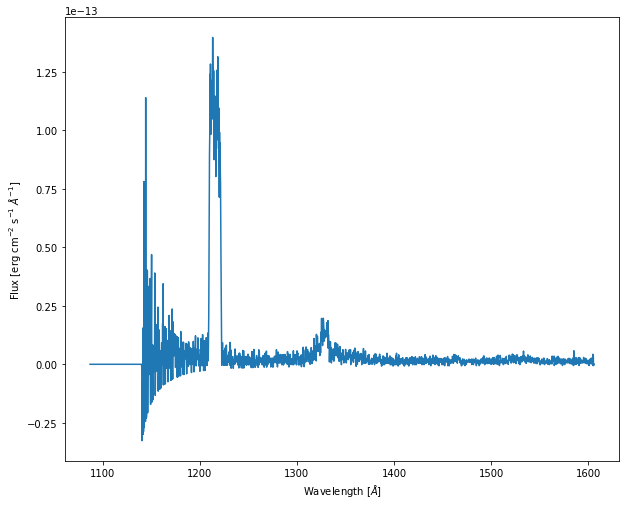

In [14]:
fig = plt.figure(figsize=(10.0, 8.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(spectrum_fits[1].data[0][0], spectrum_fits[1].data[0][1])
ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('Flux [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')

It is a spectrum in the ultraviolet with two visible emission lines, one around 1220A and one around 1330A. We know that the rest wavelength of the Lyman $\alpha$ line is at 1216A. This specrum might thus show Ly$\alpha$ (atomic hydrogen, HI) emission of the Milky Way (hardly redshifted) and of a redshifted, extragalactic source. To investigate this further, we use the `specutils` package. First we define a 1D spectrum, which is the data format that `specutils` works with. 

In [10]:
flux_unit = u.erg / u.cm**2 / u.s / u.Angstrom
spectrum = Spectrum1D(spectral_axis=spectrum_fits[1].data[0][0] * u.Angstrom, 
                      flux=spectrum_fits[1].data[0][1] * flux_unit)
# spectrum_fits.close()

Now we can use the `specutils_analysis` functions to analyse the spectrum. First we want to find out the centroid of the two lines.

In [11]:
cen_MW = spec_ana.centroid(spectrum, SpectralRegion(1200 * u.Angstrom,
                                                    1260  * u.Angstrom))
cen_new = spec_ana.centroid(spectrum, SpectralRegion(1300 * u.Angstrom,
                                                     1370  * u.Angstrom))
print('The centroid of the first peak is loacted at: ', cen_MW)
print('The centroid of the second peak is located at: ', cen_new)

The centroid of the first peak is loacted at:  1216.4767405166442 Angstrom
The centroid of the second peak is located at:  1332.9591494837025 Angstrom


Indeed the first peak is centred around the rest wavelength of the Ly$\alpha$ line. We may thus assume that this is HI emission from the Milky Way in the foreground. Now assuming that the second line is also Ly$\alpha$ emission, let's calculate the redshift and recession velocity:

In [12]:
z = (cen_new.value - 1216.) / 1216.
cz = z * 2.998e5
print('The new source has a redshift of {0:.3f} and '.format(z))
print('a recession velocity of {0:.1f} km/s '.format(cz))

The new source has a redshift of 0.096 and 
a recession velocity of 28835.8 km/s 


Although this source is much closer than the Quasar, it is still further away than the Coma Cluster and thus not a member of the Cluster. 

Alternatively to using `specutils` we can also fit the emission lines with simple Gaussians. First let's define the Gaussian:

In [15]:
def gauss(x, a, b, c):
    return (a * np.exp(-(((x - b)**2.) / (2 * c**2.))))

Next, we just take those parts of the spectrum, where the two emission lines are located:

In [16]:
index_left_line = (spectrum_fits[1].data[0][0] > 1190.) & \
                  (spectrum_fits[1].data[0][0] < 1240.)
wavelength_left_line = spectrum_fits[1].data[0][0][index_left_line]
flux_left_line = spectrum_fits[1].data[0][1][index_left_line]
index_right_line = (spectrum_fits[1].data[0][0] > 1300.) & \
                   (spectrum_fits[1].data[0][0] < 1380.)
wavelength_right_line = spectrum_fits[1].data[0][0][index_right_line]
flux_right_line = spectrum_fits[1].data[0][1][index_right_line]

Finally, we fit a Gaussian to these two junks of spectrum:

In [21]:
start_values_left_line = [1.25e-13, 1220., 10.0]
start_values_right_line = [0.2e-13, 1330., 10.0]
popt_left_line, pcov_left_line = curve_fit(gauss, wavelength_left_line, 
                                           flux_left_line, 
                                           p0=start_values_left_line)
perr_left_line = np.sqrt(np.diag(pcov_left_line))
popt_right_line, pcov_right_line = curve_fit(gauss, wavelength_right_line, 
                                             flux_right_line,
                                             p0=start_values_right_line)
perr_right_line = np.sqrt(np.diag(pcov_right_line))
print('For the left line we find the following parameter:')
print('Central wavelength: {0:.1f} +- {1:.1f}'.format(popt_left_line[1], 
                                                      perr_left_line[1]))
print('For the right line we find the following parameter:')
print('Central wavelength: {0:.1f} +- {1:.1f}'.format(popt_right_line[1], 
                                                      perr_right_line[1]))

For the left line we find the following parameter:
Central wavelength: 1215.4 +- 0.1
For the right line we find the following parameter:
Central wavelength: 1329.2 +- 0.6


These values are close to the results from the `specutils` package. 

To further check the fitting results, we plot the data, our model and residuals:

[]

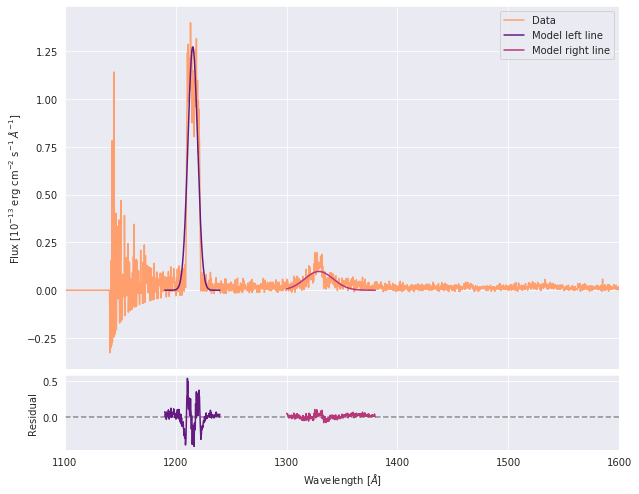

In [30]:
sns.set_style('darkgrid')

fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_axes([0.17, 0.17, 0.77, 0.13])
ax1.axhline(y=0, linestyle='--', color='#8b8b8b')
ax1.plot(wavelength_left_line, (spectrum_fits[1].data[0][1][index_left_line] - 
         gauss(wavelength_left_line, popt_left_line[0], 
               popt_left_line[1], popt_left_line[2])) * 1e13,
        label='Model left line', color=mpl.cm.magma(0.3))
ax1.plot(wavelength_right_line, (spectrum_fits[1].data[0][1][index_right_line] - 
         gauss(wavelength_right_line, popt_right_line[0], 
               popt_right_line[1], popt_right_line[2])) * 1e13,
        label='Model right line', color=mpl.cm.magma(0.5))
ax1.set_xlim([1100, 1600])
ax1.set_xlabel('Wavelength [$\AA$]')
ax1.set_ylabel('Residual')

ax2 = fig.add_axes([0.17, 0.31, 0.77, 0.63])
ax2.plot(spectrum_fits[1].data[0][0], spectrum_fits[1].data[0][1] * 1e13, 
        label='Data', color=mpl.cm.magma(0.8))
ax2.plot(wavelength_left_line, gauss(wavelength_left_line, popt_left_line[0], 
                                    popt_left_line[1], popt_left_line[2]) * 1e13,
        label='Model left line', color=mpl.cm.magma(0.3))
ax2.plot(wavelength_right_line, gauss(wavelength_right_line, popt_right_line[0], 
                                    popt_right_line[1], popt_right_line[2]) * 1e13,
        label='Model right line', color=mpl.cm.magma(0.5))
ax2.legend(loc=1, frameon=True)
ax2.set_ylabel('Flux [10$^{-13}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
ax2.set_xlim([1100, 1600])
ax2.set_xticklabels([], visible=False)

While fitting a Gaussian to the emission lines provides very good results with regards to the central wavelength (and thus redshift) of the observed object, the residuals show that in particular the emission from the Milky Way is much more complicated. 